# МО для текстов

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества F1 не меньше 0.75.

## План проекта:

<a href='#section1'>1. Загрузим данныеи подготовим их.</a>

 - <a href='#section1.a'>1.а. Добавление дополнительных признаков.</a>

 - <a href='#section1.b'>1.б. Очистка текстов.</a>

 - <a href='#section1.c'>1.с. Лемматизация текстов.</a>

<a href='#section2'>2. Обучим разные модели.</a>

 - <a href='#section2.a'>2.а. Векторизация текстов.</a>

 - <a href='#section2.b'>2.б. Подбор Логистической Регрессии.</a>
 
 - <a href='#section2.c'>2.c. Финальное тестирование.</a>

<a href='#section3'>3. Выводы.</a>




<a id='section1'></a>

## 1. Загрузим данныеи подготовим их.

In [2]:
import pandas as pd
import numpy as np
import re
import string
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
from scipy.sparse import hstack
from sklearn.model_selection import cross_val_score

df = pd.read_csv('toxic_comments.csv')

df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Подключили все необходимые библиотеки и загрузили датасет. Взглянем на целевой признак.

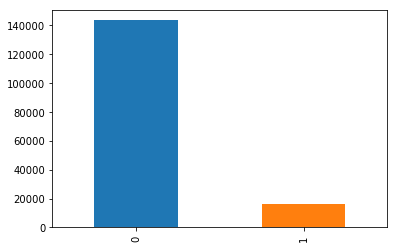

In [3]:
df['toxic'].value_counts().plot(kind='bar')
plt.show()

Виден явный дисбаланс классов. Учтем это, когда доберемся до моделей через параметр class_weight.

<a id='section1.a'></a>

## 1.a. Добавление дополнительных признаков.

Взглянем как комментарии различаются по количеству слов, количеству уникальных слов, количеству символов и количеству пунктуации. Для этого напишем функцию, которая добавит признаки в наш фрейм.

In [4]:
def add_meta_feat(df):
    df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

    df['unique_word_count'] = df['text'].apply(lambda x: len(set(str(x).split())))  

    df['char_count'] = df['text'].apply(lambda x: len(str(x)))
    
    df['punctuation_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    
    return df

In [5]:
df = add_meta_feat(df)
#Проверка
df.head()

,text,toxic,word_count,unique_word_count,char_count,punctuation_count
0,Explanation\nWhy the edits made under my usern...,0,43,41,264,10
1,D'aww! He matches this background colour I'm s...,0,17,17,112,12
2,"Hey man, I'm really not trying to edit war. It...",0,42,39,233,6
3,"""\nMore\nI can't make any real suggestions on ...",0,113,82,622,21
4,"You, sir, are my hero. Any chance you remember...",0,13,13,67,5


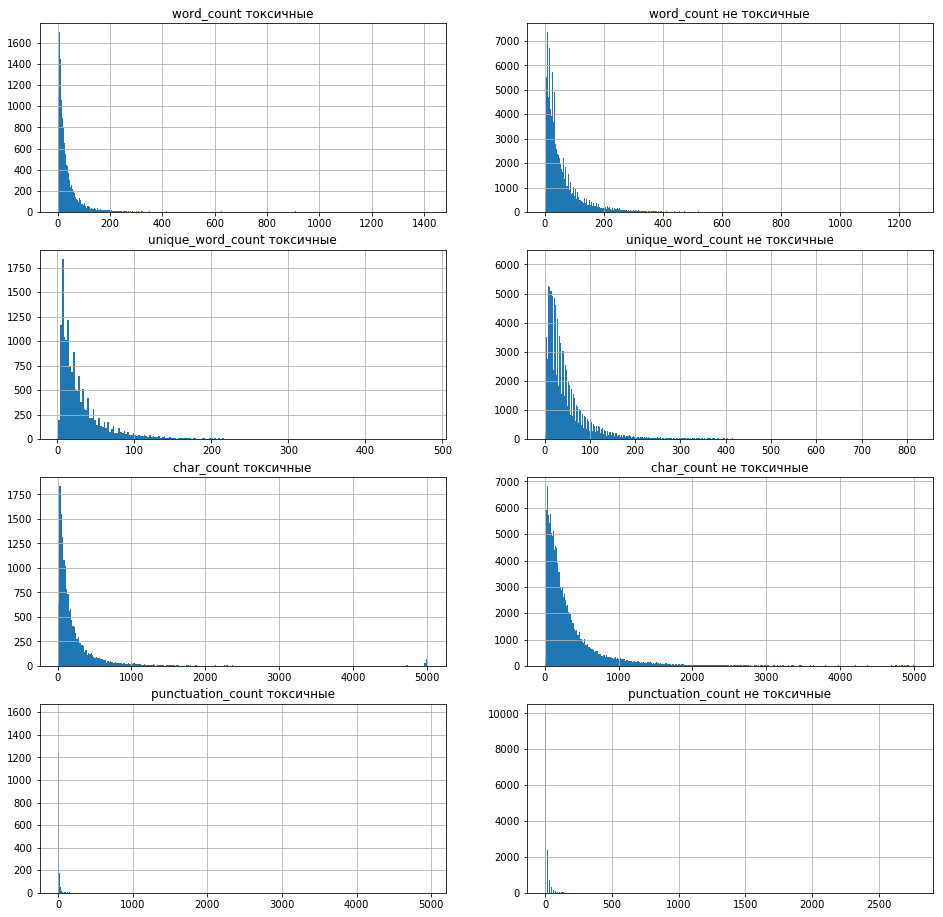

In [6]:
toxic_df = df['toxic'] == 1
added_features = ['word_count', 'unique_word_count', 'char_count', 'punctuation_count']

plt.figure(figsize=(16, 16))

k = 0
for i in range(len(added_features)):
    for j in range(2):
        plt.subplot(4,2,k+1)
        k += 1
        if j == 0:
            df[toxic_df][added_features[i]].hist(bins='fd')
            plt.title(added_features[i] + str(' токсичные'))
        else:
            df[~toxic_df][added_features[i]].hist(bins='fd')
            plt.title(added_features[i] + str(' не токсичные'))


plt.show()

Первое, что бросается в глаза - это то, что нетоксичные комментарии имеют значительно больше слов, больше букв и больше пунктуации (в 3-5 раз). Видимо когда человек пишет что-то оскорбительное он забывает про пунктуацию и старается быть как можно точнее и понятнее.

<a id='section1.b'></a>

## 1.б. Очистка текстов.

Теперь напишем функцию для очистки текстов от нелатинских букв и ненужных символов.

In [7]:
def clean(text):  
    text = text.lower()    
    text = re.sub(r"(?:\n|\r)", " ", text)
    text = re.sub(r"[^a-zA-Z ]+", "", text).strip()
    
    return text

Применим функцию к текстам и взглянем как сработала.

In [8]:
df['text_clean'] = df['text'].apply(clean)
df[['text','text_clean']]

,text,text_clean
0,Explanation\nWhy the edits made under my usern...,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,daww he matches this background colour im seem...
2,"Hey man, I'm really not trying to edit war. It...",hey man im really not trying to edit war its j...
3,"""\nMore\nI can't make any real suggestions on ...",more i cant make any real suggestions on impro...
4,"You, sir, are my hero. Any chance you remember...",you sir are my hero any chance you remember wh...
5,"""\n\nCongratulations from me as well, use the ...",congratulations from me as well use the tools ...
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,cocksucker before you piss around on my work
7,Your vandalism to the Matt Shirvington article...,your vandalism to the matt shirvington article...
8,Sorry if the word 'nonsense' was offensive to ...,sorry if the word nonsense was offensive to yo...
9,alignment on this subject and which are contra...,alignment on this subject and which are contra...


Тексты очистили, теперь займемся лемматизацией.

<a id='section1.c'></a>

## 1.c. Лемматизация текстов.

В английском языке все намного проще, чем в русском и чтобы привсти слово к начальнойформе нужно всего лишь отбросить все лишнее. Для этого воспользуемся одним из самых старых стеммеров - PorterStemmer. Он просто отбрасывает суффикс. Данный класс работает с каждым словом отдельно, поэтому для лемматизации всего текста напишем функцию.

In [9]:
def stemSentence(sentence):
    porter = PorterStemmer()
    token_words=word_tokenize(sentence)
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
    return " ".join(stem_sentence)

Посмотрим как работает.

In [10]:
corpus = list(df['text'])
stemSentence(corpus[0])

"explan whi the edit made under my usernam hardcor metallica fan were revert ? they were n't vandal , just closur on some ga after I vote at new york doll fac . and pleas do n't remov the templat from the talk page sinc I 'm retir now.89.205.38.27"

У PorterStemmer появлялась едиственная ошибка из-за одного текста. Определив его индекс, удалим его.

In [11]:
df.drop(115606, axis=0, inplace=True)

Теперь лемматизируем весь датасет.

In [12]:
tqdm.pandas()
df['text_lemma'] = df['text_clean'].progress_apply(stemSentence)

100%|██████████| 159570/159570 [05:06<00:00, 520.30it/s]


Посмотрим на результат

In [13]:
df[['text', 'text_lemma']].head()

,text,text_lemma
0,Explanation\nWhy the edits made under my usern...,explan whi the edit made under my usernam hard...
1,D'aww! He matches this background colour I'm s...,daww he match thi background colour im seeming...
2,"Hey man, I'm really not trying to edit war. It...",hey man im realli not tri to edit war it just ...
3,"""\nMore\nI can't make any real suggestions on ...",more i cant make ani real suggest on improv i ...
4,"You, sir, are my hero. Any chance you remember...",you sir are my hero ani chanc you rememb what ...


Проверим наличие пропусков.

In [14]:
df.isnull().sum()

text                 0
toxic                0
word_count           0
unique_word_count    0
char_count           0
punctuation_count    0
text_clean           0
text_lemma           0
dtype: int64

Сохраним подготовленный датасет, чтобы не производить потом лемматизацию.

In [15]:
df.to_csv('lemmatized_tweets.csv', index=False)

In [16]:
lemmatized_df = pd.read_csv('lemmatized_tweets.csv')
lemmatized_df.head()

,text,toxic,word_count,unique_word_count,char_count,punctuation_count,text_clean,text_lemma
0,Explanation\r\nWhy the edits made under my use...,0,43,41,264,10,explanation why the edits made under my userna...,explan whi the edit made under my usernam hard...
1,D'aww! He matches this background colour I'm s...,0,17,17,112,12,daww he matches this background colour im seem...,daww he match thi background colour im seeming...
2,"Hey man, I'm really not trying to edit war. It...",0,42,39,233,6,hey man im really not trying to edit war its j...,hey man im realli not tri to edit war it just ...
3,"""\r\nMore\r\nI can't make any real suggestions...",0,113,82,622,21,more i cant make any real suggestions on impro...,more i cant make ani real suggest on improv i ...
4,"You, sir, are my hero. Any chance you remember...",0,13,13,67,5,you sir are my hero any chance you remember wh...,you sir are my hero ani chanc you rememb what ...


После загрузки ранее сохраненного датасета появилось 7 пропусков. Не понял откуда они, но для корректной работы моделей удалим их.

In [17]:
print(lemmatized_df.shape)
lemmatized_df.dropna(inplace=True)
print(lemmatized_df.shape)

(159570, 8)
(159563, 8)


<a id='section2'></a>

## 2. Обучим разные модели.

Нормализуем числовые признаки и разобьем датасет для обучения и проверки моделей.

In [18]:
features = lemmatized_df.drop(columns=['text', 'text_clean','toxic'])
targets = lemmatized_df['toxic']

scaler          = StandardScaler()
scaler.fit(features[added_features])
features[added_features] = scaler.transform(features[added_features])

train_features, test_features, train_targets, \
                            test_targets = train_test_split(features, targets, test_size=.2, random_state=12345)

<a id='section2.a'></a>

## 2.a. Векторизация текстов.

Теперь напишем функцию, которая превратит тексты в вектора (понятный для машин формат). К полученной матрице добавим наши доп признаки.

In [19]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

def tf_idf_features(df, is_train=True):
    corpus = list(df['text_lemma'])
    if is_train:
        tf_idf = count_tf_idf.fit_transform(corpus)
    else:
        tf_idf = count_tf_idf.transform(corpus)
    add_feat = sparse.csr_matrix(df[added_features].values)
    result = hstack((tf_idf, add_feat))
    return result

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<a id='section2.b'></a>

## 2.б. Подбор Логистической Регрессии.

In [20]:
model = LogisticRegression(solver='liblinear', max_iter=500, random_state=12345, class_weight='balanced')

tf_features_train = tf_idf_features(train_features)
scores = cross_val_score(model, tf_features_train, train_targets, cv=5, scoring='f1')
f1_mean = scores.mean()
print('F1-score = {:.4f}'.format(f1_mean))

F1-score = 0.7513


Метрика уже неплоха, но подберем для нашей модели гиперпараметр C, отвечающий за регуляризцию.

Сначала поиск будем производить с большим шагом.

In [21]:
grid={"C":np.logspace(-3,3,7),'solver':['liblinear']}

logreg=LogisticRegression(max_iter=500)
logreg_cv=GridSearchCV(logreg,grid,cv=5)
logreg_cv.fit(tf_features_train,train_targets)
logreg_cv.best_params_

{'C': 10.0, 'solver': 'liblinear'}

Теперь пройдемся вокруг наилучшего значения.

In [25]:
# grid={"C":np.arange(5,30,2),'solver':['liblinear']}

# logreg=LogisticRegression(max_iter=500)
# logreg_cv=GridSearchCV(logreg,grid,cv=5)
# logreg_cv.fit(tf_features_train,train_targets)
# logreg_cv.best_params_

In [23]:
model = LogisticRegression(solver='liblinear', max_iter=500, random_state=12345, class_weight='balanced',C=9)

tf_features_train = tf_idf_features(train_features)
scores = cross_val_score(model, tf_features_train, train_targets, cv=5, scoring='f1')
f1_mean = scores.mean()
print('F1-score = {:.4f}'.format(f1_mean))

F1-score = 0.7643


Метрику улучшили.

<a id='section2.c'></a>

## 2.c. Финальное тестирование.

In [24]:
model = LogisticRegression(solver='liblinear', max_iter=500, random_state=12345, class_weight='balanced', C=9)
tf_features_train = tf_idf_features(train_features)
model.fit(tf_features_train, train_targets)

tf_features_test = tf_idf_features(test_features, is_train=False)
pred = model.predict(tf_features_test)
print('F1-score = {:.4f}'.format(f1_score(test_targets, pred)))

F1-score = 0.7700


Цель достигнута.

<a id='section3'></a>

## 3. Выводы.

В данном проекте мы, сперва, провели небольшой анализ текстов и выяснили, что у оскорбительных комментариев меньше слов, букв и знаков препинания. Далее мы очистили тексты, лемматизировали и перевели в понятный для машины формат - векторный. Под конец мы с помощью GridSearchCV подобрали наилучший набор гиперпараметров для Логистической регрессии и на финальном этапе проверили ее в действии на тестовой выборке.